In [25]:
import numpy as np
from scipy import constants as C
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize
import twutils.pre

mpl.rcParams.update({'text.usetex' : True , 'font.size' : 10})

# Using mks units, normalize only at the end
nc = (2*np.pi*C.c/0.8e-6)**2 * C.epsilon_0 * C.m_e / C.e**2
su = twutils.pre.SimUnits(nc*1e-6)
print(nc)

1.7419597153612948e+27


In [26]:
# Basic functions
def DF(w,res,gam):
    return res**2 - 2*1j*w*gam - w**2
def chiBBO(w):
    lum = 1e6*2*np.pi*C.c/w
    chi_o = 1.7359 + 0.01878/(lum**2-.01822) - .01354*lum**2
    chi_e = 1.3753 + 0.01224/(lum**2-.01667) - .01516*lum**2
    return ( chi_o , chi_o , chi_e )
def chi_osc(w,f,wp,res,gam):
    return f*wp**2/DF(w,res,gam)
def contraction(j,k):
    l = j
    if j!=k and j in (1,2) and k in (1,2):
        l = 3
    if j!=k and j in (0,2) and k in (0,2):
        l = 4
    if j!=k and j in (0,1) and k in (0,1):
        l = 5
    return l
def uncontract(l):
    if l==0:
        return 0,0
    if l==1:
        return 1,1
    if l==2:
        return 2,2
    if l==3:
        return 1,2
    if l==4:
        return 0,2
    return 0,1
    

oscillator 1: n = 18.03760330545057 f = [5.1232871  5.1232871  4.91001522] res = [7.31151008 7.31151008 8.0392084 ]
oscillator 2: n = 0.0018037603305450574 f = [2.5505767  2.5505767  3.84848428] res = [3.46430165e-06 3.46430165e-06 3.48088353e-05]


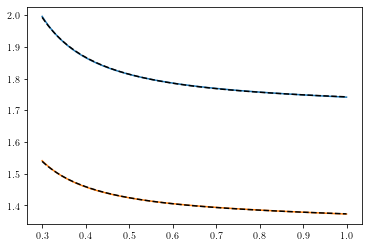

In [27]:
# Setup linear dispersion parameters
# We use a 2D array such that e.g. res[s,i] is the resonant frequency
# for oscillator s, along axis i
wp = np.array([1e16,1e14])
def chi_2osc(w,f1,res1,f2,res2):
    o1 = chi_osc(w,f1,wp[0],res1,0.0)
    o2 = chi_osc(w,f2,wp[1],res2,0.0)
    return np.real(o1+o2)

f = np.ones((2,3))
gam = np.zeros((2,3))
res = np.ones((2,3))
l = np.linspace(0.3e-6,1e-6,100)
w = 2*np.pi*C.c/l
chi_o = chiBBO(w)[0]
chi_e = chiBBO(w)[2]
owave = scipy.optimize.curve_fit(chi_2osc,w,chi_o,[1,1e16,1,1e12],bounds=([0.0,0.0,0.0,0.0],[10,1e17,10,1e17]))
ewave = scipy.optimize.curve_fit(chi_2osc,w,chi_e,[1,1e16,1,1e12],bounds=([0.0,0.0,0.0,0.0],[10,1e17,10,1e17]))

f[0,0:2] = owave[0][0]
res[0,0:2] = owave[0][1]
f[1,0:2] = owave[0][2]
res[1,0:2] = owave[0][3]
chi_o_fit = chi_2osc(w,f[0,0],res[0,0],f[1,0],res[1,0])

f[0,2] = ewave[0][0]
res[0,2] = ewave[0][1]
f[1,2] = ewave[0][2]
res[1,2] = ewave[0][3]
chi_e_fit = chi_2osc(w,f[0,2],res[0,2],f[1,2],res[1,2])

print('oscillator 1: n =',(su.t1*wp[0])**2,'f =',f[0,:],'res =',res[0,:]*su.t1)
print('oscillator 2: n =',(su.t1*wp[1])**2,'f =',f[1,:],'res =',res[1,:]*su.t1)

plt.figure(1)
plt.plot(l*1e6,chi_o)
plt.plot(l*1e6,chi_o_fit,'k--')
plt.plot(l*1e6,chi_e)
plt.plot(l*1e6,chi_e_fit,'k--')
plt.show()

In [28]:
# We have to pick a nonlinear process and associated frequencies
w1 = 2*np.pi*C.c/0.8e-6
w2 = 2*np.pi*C.c/0.8e-6
w3 = w1+w2
# 1=xx,2=yy,3=zz,4=yz,5=zx,6=xy
dBBO = np.array([[0,0,0,0,.08,2.2],[2.2,-2.2,0,.08,0,0],[.04,.04,.04,0,0,0]])*1e-12
d = dBBO
a = np.zeros((3,6))
# Form anharmonic tensor - OK for w1=w2, what if w1!=w2?
for i in range(3):
    for l in range(6):
            j,k = uncontract(l)
            a[i,l] = -2*C.m_e*d[i,l]/C.e
            a[i,l] *= np.real(DF(w3,res[0,i],0.0))
            a[i,l] *= np.real(DF(w1,res[0,j],0.0))
            a[i,l] *= np.real(DF(w2,res[0,k],0.0))
            a[i,l] /= f[0,i] * wp[0]**2
print('d =',d)
print('a[mks] =',np.array2string(a,precision=2))
print('a[su] =',np.array2string(a*su.x1*su.t1**2,precision=2))

d = [[ 0.0e+00  0.0e+00  0.0e+00  0.0e+00  8.0e-14  2.2e-12]
 [ 2.2e-12 -2.2e-12  0.0e+00  8.0e-14  0.0e+00  0.0e+00]
 [ 4.0e-14  4.0e-14  4.0e-14  0.0e+00  0.0e+00  0.0e+00]]
a[mks] = [[-0.00e+00 -0.00e+00 -0.00e+00 -0.00e+00 -4.99e+40 -1.13e+42]
 [-1.13e+42  1.13e+42 -0.00e+00 -4.99e+40 -0.00e+00 -0.00e+00]
 [-2.63e+40 -2.63e+40 -3.87e+40 -0.00e+00 -0.00e+00 -0.00e+00]]
a[su] = [[    -0.       -0.       -0.       -0.    -1147.12 -26007.56]
 [-26007.56  26007.56     -0.    -1147.12     -0.       -0.  ]
 [  -604.85   -604.85   -889.87     -0.       -0.       -0.  ]]
